# Model selection
## Introduction
The goal of this notebook is to illustrate some basic strategies for model selection . In the first part, you have explored the fitness paramaeters; this second part focuses on the search of one (or some) final predicitve model(s).

Below you have the code developed for this laboratory.

In [1]:
#Code for the app
import os, glob, time
import numpy as np
import csv
import matplotlib.pyplot as plt
import re
import pylab as pl
import csv
import pandas as pd
import copy

from collections import OrderedDict


pathLogs = ""
pathDataSet = ""
pathWriteFilesSyst = ""
minSen = 0.75
minSpe = 0.75

#Fonctions----------------
def getAllLogs(pathFile, typeFile):
    listFiles = []
    for path, dirs, files in os.walk(pathFile):
        for filename in files:
            if filename.find(typeFile) != -1 and len(filename) > 50:
                search = os.path.join(path, filename)
                listFiles.append(search)
    return listFiles

def getResultsDrawGrafSpeSen(listOfFiles):
    vecSens = []
    vecSpe = []
    for fileElement in listOfFiles:
        cr = csv.reader(open(fileElement,"r"))
        for row in cr:
            if len(row) >= 1:
                if '#Sensitivity;' in row[0]:
                    valueParams =  row[0].split(';')[1]
                    vecSens.append(valueParams)
                if '#Specificity;' in row[0]:
                    valueParams =  row[0].split(';')[1]
                    vecSpe.append(valueParams)
    return vecSens, vecSpe

def setDrawSenSpe(vecSens, vecSpe):
    plt.scatter(vecSens, vecSpe, s=5, facecolors='none', edgecolors='r')
    plt.xlabel("Sensitivity")
    plt.ylabel("Specificity")
    plt.title("Results", fontsize=14, fontweight='bold')
    plt.show()
    
    
def getDictVars(pathDataSet):
    dictionaryVars = {}
    dictPathSystems = {}
    cr = csv.reader(open(pathDataSet,"r"))
    firstLine = next(cr)
    varVec = firstLine[0].split(';')
    qtdvar = len(varVec)
    aux = 1
    while aux < qtdvar-1:
        dictionaryVars[varVec[aux]] = 0
        dictPathSystems[varVec[aux]] = []
        aux = aux + 1
    return dictionaryVars, dictPathSystems

def countVariables(dictVar, dictVarBySystems, listFiles, dictPathVar):
    for fileGood in listFiles:
        dictAux = dictVar.copy()
        vecRules = openCSVGetFSystem(fileGood)
        for rule in vecRules:
            dictVar = addValueVariable(dictVar, rule)
        dictVarBySystems, dictPathVar = countVarSystem(dictAux, dictVar, dictVarBySystems, dictPathVar, fileGood)
    return dictVar, dictVarBySystems, dictPathVar

def openCSVGetFSystem(pathFile):
    vecFS = []
    cr = csv.reader(open(pathFile,"rb"))
    for row in cr:
        if len(row) >= 1:
            if ' IF ' in row[0]:
                vecFS.append(row[0])
    return vecFS

def addValueVariable(dictVar, ruleDesign):
    for keysValue in dictVar.keys():
        if keysValue in ruleDesign:
            dictVar[keysValue] = dictVar[keysValue] + 1
    return dictVar


def countVarSystem(dictAux, dictNow, dictVarSyst, dictPathVar, filePath):
    for keyValue in dictAux.keys():
        if dictNow[keyValue] > dictAux[keyValue]:
            dictVarSyst[keyValue] = dictVarSyst[keyValue] + 1
            dictPathVar[keyValue].append(filePath)
    return dictVarSyst, dictPathVar

def getBestSystem(minSensitivity, minSpecificity, listOfFiles):
    minSen = False
    minSpe = False
    vecBestSys = []
    for fileElement in listOfFiles:
        minSen = False
        minSpe = False
        cr = csv.reader(open(fileElement,"r"))
        for row in cr:
            if len(row) >= 1:
                if '#Sensitivity;' in row[0]:
                    valueParams =  row[0].split(';')[1]
                    if float(valueParams) > minSensitivity:
                        minSen = True
                        #vecBestSys.append(fileElement)
                if '#Specificity;' in row[0]:
                    valueParams =  row[0].split(';')[1]
                    if float(valueParams) > minSpecificity:
                        minSpe = True
        if minSpe is True and minSen is True:
            vecBestSys.append(fileElement)
    return vecBestSys 

def write_datafram_var(qty_models, dict_freq_vars):
    df = pd.DataFrame(dict_freq_vars.items(), columns=['name', 'frequency'])
    df = df.sort_values(['frequency'], ascending=[0])
    df = df.reset_index(drop=True)
    df['percent'] = df.ix[:,'frequency':].sum(axis=1)/qty_models * 100
    df = df.drop(df[df.frequency == 0].index)
    print df

def plot_histogram(data_values, data_label):
    ax = plt.subplot(111)
    width=0.3
    bins = map(lambda x: x-width/2,range(1,len(data_values)+1))
    ax.bar(bins,vec_qty_threshold,width=width)
    ax.set_xticks(map(lambda x: x, range(1,len(data_label)+1)))
    ax.set_xticklabels(vec_value_threshold,rotation=45)
    plt.xlabel("Filtering threshold")
    plt.ylabel("Number of models")
    plt.title("Number of models remaining after filtering", fontsize=14, fontweight='bold')
    plt.show()
    
def removeVariablesNull(dictValuesVar):
    dictValues = {}
    dictPath = {}
    for keyDict in dictValuesVar.keys():
        if dictValuesVar[keyDict] > 0:
            dictValues[keyDict] = dictValuesVar[keyDict]
    return dictValues

def removeVariablesNullValuesArr(dictValuesArr):
    dictValuesArrFull = {}
    for keyDict in dictValuesArr.keys():
        if len(dictValuesArr[keyDict]) > 0:
            dictValuesArrFull[keyDict] = dictValuesArr[keyDict]
    return dictValuesArrFull

def writeFilesCSV(dictVarsPath, pathFile):
    with open(pathFile, 'wb') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in dictVarsPath.items():
            writer.writerow([key, value])
        
def writeFilesCSVDS(list_ds, pathFile):
    with open(pathFile, 'wb') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(list_ds)

def orderDictByVar(dictValues):
    vecValues = []
    vecKeys = []
    dictFreVarSort = sorted(dictValues.items(), key=lambda x: x[1], reverse=True)
    for element in dictFreVarSort:
        vecValues.append(element[0])
        vecKeys.append(element[1])
    return vecValues, vecKeys

def generateGraph(vValues, vLables):
    vValues.insert(0,0)
    vLables.insert(0,'5')
    X = np.arange(len(vLables))
    pl.bar(X, vValues, align='center', width=0.5)
    pl.xticks(X, vLables, rotation='vertical')
    ymax = max(vValues)
    pl.ylim([0, ymax + 10])
    pl.xlim([0.5, X.size - 0.5])
    pl.xlabel("Feature")
    pl.ylabel("Frequency")
    pl.suptitle("Feature ranking by frequency", fontsize=14, fontweight='bold')
    pl.axhline(y=np.mean(vValues), xmin=0, xmax=1, hold=None)
    pl.show()
    
def removeModels(qtdDelete, dictQtd, dictModels):
    vecFiles = []
    for keyDict, valueDict in dictQtd.items():
        if valueDict < qtdDelete:
            vecFiles = list(set(vecFiles + dictModels[keyDict]))
    return vecFiles

    
def removeModelsFromDics(listModels, dictQtd, dictModels):
    for model in listModels:
        for keyDict, valueDict in dictModels.items():
            if model in valueDict:
                idx = valueDict.index(model)
                dictModels[keyDict].pop(idx)
                dictQtd[keyDict] = dictQtd[keyDict] - 1
    return dictQtd, dictModels

def getNbModels(dictValues):
    vecPaths = []
    for indexDict, valueDict in dictValues.items():
        for valuePathInfo in valueDict:
            if valuePathInfo not in vecPaths:
                vecPaths.append(valuePathInfo)
    return vecPaths

def get_qty_modelb_by_var_freq(max_val_freq_var, dqwzbs_A, dqvwzbvp_B):

    qtd_models = np.zeros(max_val_freq_var)
    aux = 0
    while aux < max_val_freq_var:
        dqwzbs_A_rem = copy.deepcopy(dqwzbs_A)
        dqvwzbvp_B_rem = copy.deepcopy(dqvwzbvp_B)
        dictModelsLimit = removeModels(aux, dqwzbs_A_rem, dqvwzbvp_B_rem)

        dictQtdVarsLimit, dictFilesPathRest = removeModelsFromDics(dictModelsLimit, dqwzbs_A_rem, dqvwzbvp_B_rem)
    
        dictFilesPathRestWithoutZeros = removeVariablesNullValuesArr(dictFilesPathRest)

    
        qtdModelsAfterCut = getNbModels(dictFilesPathRestWithoutZeros)
        qtd_models[aux] = len(qtdModelsAfterCut)
        aux = aux + 1
    return qtd_models

def plot_line_freq_var_models(x_values,y_values):
    plt.xlabel("Feature frequency")
    plt.ylabel("Number of models")
    plt.suptitle("Feature importance", fontsize=14, fontweight='bold')
    plt.plot(x_values, y_values)
    plt.show()
    
def get_log_by_dict(dict_values):
    list_log_val = []
    for key, value in dict_values.iteritems():
        for val in value:
            if val not in list_log_val:
                list_log_val.append(val)
    return list_log_val
#End fonctions------------

## Exploration of model complexity space: Rules and variables-per-rule

During the first part of the laboratory we have selected the best parameter values for fitness weights (i.e., RMSE, size, sensitivity, and specificity). Now we want to explore the model complexity space, i.e., the number of rules and variables per rule of the models. To do this open the script that we sent you (MileRef.fs) and modify so as to:
- set the fitness weights with the values chosen in the first part
- set the size of both populations to 120 and run lengths to 200 generations
- perform a grid search with the following parameters:
    - number of rules: 1, 3, and 5
    - number of variables per rule: 1, 3, and 5
- repeat each experience 5 times
    
Note: A deeper exploration would require exploring some more combinations of parameters as well as, either or both, running more generations and using bigger populations. This would effect, nevertheless, the computational cost.

#### Before continuing:
Once finished, you should put all the <u>log files</u> in the same directory (i.e., those obtained in the first part plus the newly obtained). 

## Model selection 1: filtering by performance

The first step in model selection seeks at eliminating the worst-performing models. To do so, a simple trheshold is applied to both criteria Sensitivity and Specificity.

The script in the cell below will, first, ask you for the following three paths:
- The directory of log files
- The path to the dataset (mile)
- A file (with path) to save the selected models

After the execution of the next cell you will obtain (1) the distribution of your models according to their sensitivity and specificity, (2) a table ranking the most frequent features (number of models where they appear), and (3) a histogram that shows you the number of models that would remain after filtering according to the threshold used.

Log file path: 
 E.g: /home/mlbd/Desktop/mile/logs (Enter to select)
 Logs Documents path: /home/mlbd/Desktop/Mile/logsC/logs
---------------------------------------
Dataset path: 
 E.g: /home/mlbd/Desktop/FUGE/mile/Mile_train.csv (Enter to select)
 DataSet path: /home/mlbd/Desktop/Mile/Mile.csv
---------------------------------------
Path to save the models: 
 E.g: /home/mlbd/Desktop/MLBD/PathsSystems.csv (Enter to select)
 Path Systems: /home/mlbd/Desktop/Mile/Path.csv
---------------------------------------


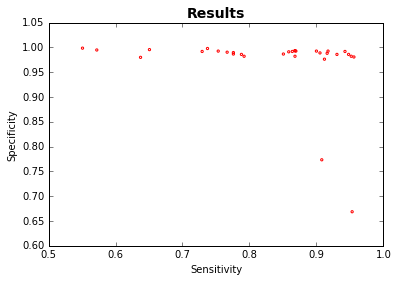

             name  frequency    percent
0       210487_at         17  54.838710
1       207550_at         17  54.838710
2       243363_at         17  54.838710
3      1552892_at         16  51.612903
4       213539_at         16  51.612903
5       203047_at         16  51.612903
6       235333_at         15  48.387097
7       221349_at         15  48.387097
8     204619_s_at         15  48.387097
9       203063_at         15  48.387097
10    202123_s_at         15  48.387097
11     1558871_at         15  48.387097
12      209369_at         15  48.387097
13    201809_s_at         15  48.387097
14      205372_at         15  48.387097
15      229738_at         15  48.387097
16    206398_s_at         14  45.161290
17    243618_s_at         14  45.161290
18    211031_s_at         14  45.161290
19      227646_at         14  45.161290
20      201540_at         14  45.161290
21      221969_at         14  45.161290
22    216379_x_at         14  45.161290
23    243462_s_at         14  45.161290


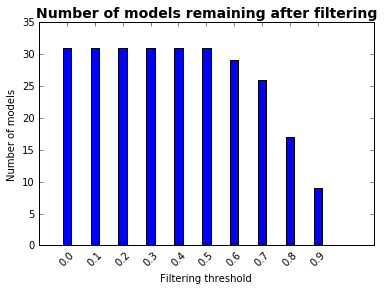

---------------
you have 31 models and 210 variables
---------------


In [2]:
print "Log file path: "
print " E.g: /home/mlbd/Desktop/mile/logs (Enter to select)"
pathLogs = raw_input(" Logs Documents path: ")
print "---------------------------------------"
print "Dataset path: "
print " E.g: /home/mlbd/Desktop/FUGE/mile/Mile_train.csv (Enter to select)"
pathDataSet = raw_input(" DataSet path: ")
print "---------------------------------------"
print "File to save the models: "
print " E.g: /home/mlbd/Desktop/MLBD/PathsSystems.csv (Enter to select)"
pathWriteFilesSyst = raw_input(" Path Systems: ")
print "---------------------------------------"

listLogs =  getAllLogs(pathLogs, ".csv")

vecSensitivity, vecSpecificity = getResultsDrawGrafSpeSen(listLogs)
setDrawSenSpe(vecSensitivity, vecSpecificity)

dictVars, dictPath = getDictVars(pathDataSet)
dictVarsBySystem = dictVars.copy()
dictQtdVar, dictVarsBySystem, dictPathVar = countVariables(dictVars, dictVarsBySystem, listLogs, dictPath)


write_datafram_var(len(listLogs), dictVarsBySystem)

print "---------------"
print "you have " + str(len(listLogs)) + " models and " + str(np.count_nonzero(dictVarsBySystem.values())) + " variables"
print "---------------"

#Threshold range
vec_value_threshold = np.arange(0.0, 1.0, 0.05)
vec_qty_threshold = np.zeros(len(vec_value_threshold))
aux = 0
for values in vec_value_threshold:
    listBestSystms = getBestSystem(float(values), float(values), listLogs)
    vec_qty_threshold[aux] = len(listBestSystms)
    aux = aux +1

plot_histogram(vec_qty_threshold, vec_value_threshold)


Now, before running the next cell, analyze the results you just obtained and select a threshold value that allows you to keep around <b>one third</b> of the models (but, at least 30%). Write below the selected threshold value.
- Note 1: if necessary you may modify the vector of performance thresholds so as to fine tune the selection
- Note 2: if you have too many rows in the table (i.e., too many variables), you can change the print in the method "write_datafram_var" (e.g., print df to print df.head(15)).

<p style="background-color:#AFB7FF;padding:3px"><b>Write here your selected threshold value, comment very briefly your choice (was it straightforward to make? does it make sense? etc.)  </b></p>

---------------
you have 31 models and 210 variables
---------------
 Enter your threshold value: (default: 0.75)
Value: 0.9
0.9


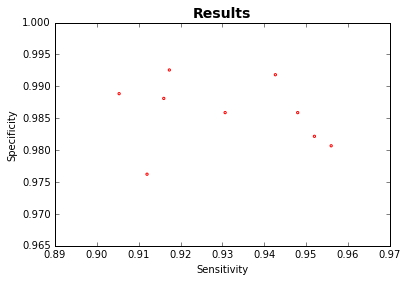

             name  frequency    percent
0       202085_at          6  66.666667
1       231935_at          5  55.555556
2       210487_at          5  55.555556
3       205372_at          5  55.555556
4     202123_s_at          5  55.555556
5       212012_at          5  55.555556
6       203585_at          5  55.555556
7     206398_s_at          5  55.555556
8       235333_at          4  44.444444
9     204619_s_at          4  44.444444
10    216379_x_at          4  44.444444
11   1553808_a_at          4  44.444444
12     1552892_at          4  44.444444
13      209369_at          4  44.444444
14    209170_s_at          4  44.444444
15     44790_s_at          4  44.444444
16      206674_at          4  44.444444
17    221558_s_at          4  44.444444
18      201417_at          4  44.444444
19      205081_at          4  44.444444
20      221349_at          4  44.444444
21    203355_s_at          4  44.444444
22      203787_at          4  44.444444
23   1555705_a_at          4  44.444444


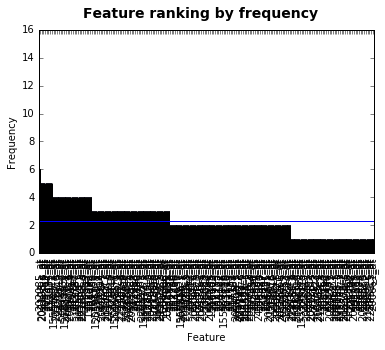

---------------
you have 9 models and 193 variables
---------------


In [3]:
print "---------------"
print "Remond, you have now " + str(len(listLogs)) + " models and " + str(np.count_nonzero(dictVarsBySystem.values())) + " variables"
print "---------------"

print " Enter your perfromance (Sens&Spec) threshold value: (default: 0.75)"
threshold_val = raw_input("Value: ") or "0.75"
threshold_val = float(threshold_val)
print threshold_val

#Get the systems that have more than threshold_val (based on sensitivity and specificity)
listLogs = getBestSystem(threshold_val, threshold_val,listLogs)

#Prepare the data for plotting the models
vecSensitivity, vecSpecificity = getResultsDrawGrafSpeSen(listLogs)
setDrawSenSpe(vecSensitivity, vecSpecificity)

#Analyse the frequency of the variables of the systems selected
dictVars, dictPath = getDictVars(pathDataSet)
dictVarsBySystem = dictVars.copy()
dictQtdVar, dictVarsBySystem, dictPathVar = countVariables(dictVars, dictVarsBySystem, listLogs, dictPath)

#Write the information table about the variables
write_datafram_var(len(listLogs), dictVarsBySystem)

#Save the best systems
dictQtdVarWithouZerosBySys = removeVariablesNull(dictVarsBySystem)
dictQtdVarWithouZerosByVarPath = removeVariablesNullValuesArr(dictPathVar)
  
# writes the best systems in the "pathWriteFilesSyst" file
writeFilesCSV(dictQtdVarWithouZerosByVarPath, pathWriteFilesSyst)

#plot the histogram     
labels, results = orderDictByVar(dictQtdVarWithouZerosBySys)
generateGraph(results, labels)

print "---------------"
print "After filtering you have " + str(len(listLogs)) + " models and " + str(np.count_nonzero(dictVarsBySystem.values())) + " variables"
print "---------------"

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>1. </b></font>Analyse the results obtained (e.g., number of models, number of variables, ). What can you conclude? Discuss briefly</p>

Your answer here

## Model selection 2: filtering by frequency

In the second step, we will use the frequency of the variables as criterion to perform model and feature selection.
Running the cell below, you will obtain a plot representing the number of models remaining after filtering, according to a given frequency threshold applied. In this case, the filter works as follows: the variables that are less frequent than the threshold are marked to be eliminated and, consequently, all the models using them are eliminated from the pool of models.
<p>Again, select a value that allows keeping around a third of the models. (So, you will then have around 10% of the original pool of models.)

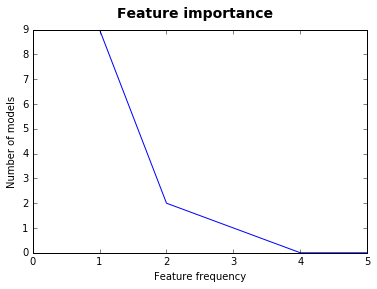

In [4]:
value = np.amax(results)

dictQtdVarWithouZerosBySys_rem = copy.deepcopy(dictQtdVarWithouZerosBySys)
dictQtdVarWithouZerosByVarPath_rem = copy.deepcopy(dictQtdVarWithouZerosByVarPath)


vec_qty_models = get_qty_modelb_by_var_freq(value, dictQtdVarWithouZerosBySys_rem, dictQtdVarWithouZerosByVarPath_rem)
x_values = np.arange(0, value, 1)


plot_line_freq_var_models(x_values, vec_qty_models)



<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>2. </b></font> One simple option would be to set the filter to 1 (i.e., eliminating all the variables that appear only once). Do you think it is important to delete the models that contain features that appear just once? Why? When it is important to save them?</p>

Your answer here

<p style="background-color:#AFB7FF;padding:3px"><b>Write here the frequency threshold your choose to use. Comment briefly your choice.</b></p>

---------------
you have 9 models and 193 variables
---------------
Enter the feature frequency limit: 
 Default: 0 (Enter to select)
 Limit: 2


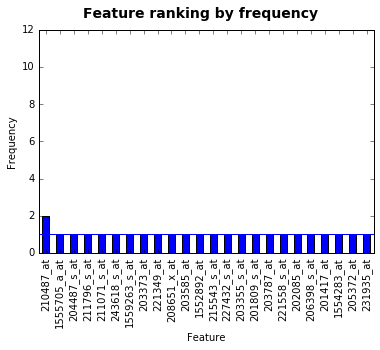

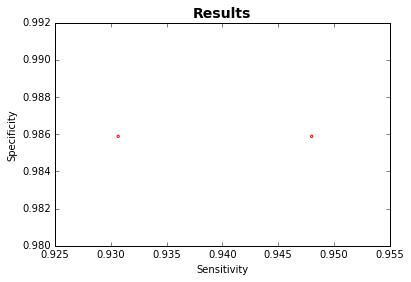

            name  frequency    percent
0      210487_at          2  22.222222
1   1559263_s_at          1  11.111111
2    215543_s_at          1  11.111111
3      202085_at          1  11.111111
4    211071_s_at          1  11.111111
5    221558_s_at          1  11.111111
6      201417_at          1  11.111111
7     1552892_at          1  11.111111
8      205372_at          1  11.111111
9    201809_s_at          1  11.111111
10   227432_s_at          1  11.111111
11   203355_s_at          1  11.111111
12   243618_s_at          1  11.111111
13   204487_s_at          1  11.111111
14     221349_at          1  11.111111
15     203585_at          1  11.111111
16    1554283_at          1  11.111111
17     203787_at          1  11.111111
18  1555705_a_at          1  11.111111
19     203373_at          1  11.111111
20     231935_at          1  11.111111
21   208651_x_at          1  11.111111
22   206398_s_at          1  11.111111
23   211796_s_at          1  11.111111
---------------
you have 

In [5]:
print "---------------"
print "you have " + str(len(listLogs)) + " models and " + str(np.count_nonzero(dictVarsBySystem.values())) + " variables"
print "---------------"
print "Enter the feature frequency limit: "
print " Default: 0 (Enter to select)"
limitCut = raw_input(" Limit: ") or int(0)

#Copy the data that contain the informations about the frequency and log path where
#appear each variable
dictQtdVarWithouZerosBySys_rem = dictQtdVarWithouZerosBySys.copy()
dictQtdVarWithouZerosByVarPath_rem = dictQtdVarWithouZerosByVarPath.copy()

#Remove the models that the variables don't have the minimum frequency
dictModelsLimit = removeModels(int(limitCut), dictQtdVarWithouZerosBySys_rem, dictQtdVarWithouZerosByVarPath_rem)
dictQtdVarsLimit, dictFilesPathRest = removeModelsFromDics(dictModelsLimit, dictQtdVarWithouZerosBySys_rem, dictQtdVarWithouZerosByVarPath_rem)
dictQtdVarsLimitWithoutZero = removeVariablesNull(dictQtdVarsLimit)  
dictFilesPathRestWithoutZeros = removeVariablesNullValuesArr(dictFilesPathRest)
 

#qtdModelsBeforeReduction = np.sum(results)
labels, results = orderDictByVar(dictQtdVarsLimitWithoutZero)
  
#Generate the histogram with the variables frequency
generateGraph(results, labels)

#plot sensitivity specificity graph
log_list_val = get_log_by_dict(dictFilesPathRestWithoutZeros)
vecSensitivity, vecSpecificity = getResultsDrawGrafSpeSen(log_list_val)
setDrawSenSpe(vecSensitivity, vecSpecificity)

#Wite the table that contain the frequency information of each variable
dictVars, dictPath = getDictVars(pathDataSet)
dictVarsBySystem = dictVars.copy()
dictQtdVar, dictVarsBySystem, dictPathVar = countVariables(dictVars, dictVarsBySystem, log_list_val, dictPath)
write_datafram_var(len(listLogs), dictVarsBySystem)


# writes the best systems in the "pathWriteFilesSyst" file
writeFilesCSVDS(log_list_val, pathWriteFilesSyst)

print "---------------"
print "you have " + str(len(log_list_val)) + " models and " +  str(np.count_nonzero(dictVarsBySystem.values())) + " variables"
print "---------------"

## Validation

Now, open the file containing your saved models (the one defined during the first step). Then, open the corresponding fuzzy model in FUGE. (e.g.: if you have: ZurichSIB2016_15:45:19.424863638Gen400_Pop200_Rules3_Elt5_CX0.9_MutI0.2_MutB0.025_FixedV0_Fit0.820597.<b>csv</b> the corresponding model is in the fuzzy systems path with the same name but finished with <b>.fs</b>)

To do this:
- open FUGE-> section Fuzzy System -> open. 
- open the validation set: Fuge-> section Fuzzy System -> Evaluate

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>3. </b></font>Comparing the results between the test and train test, what do you conclude?</p>

Your answer here

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>4. </b></font>Do you think, this approach is good to select the best model? Why? What could you suggest to improve it?</p>

Your answer here